# Coursera IBM Data Science Certificate (so far only week 4)
## Capstone Project week 4+5
### Please find the introduction, methodology etc in the report.

## a.) Import libraries

In [49]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [50]:
!pip -q install folium==0.5.0
import folium

In [51]:
!pip -q install geocoder
import geocoder

In [52]:
!pip -q install requests
import requests

## b.) Pull top 50 US cities Dataframe
The following dataframe includes the names and populations of the top 50 US cities

In [53]:
df = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")[4][["City", "2018estimate"]].iloc[:50]
df

,City,2018estimate
0,New York[d],8398748
1,Los Angeles,3990456
2,Chicago,2705994
3,Houston[3],2325502
4,Phoenix,1660272
5,Philadelphia[e],1584138
6,San Antonio,1532233
7,San Diego,1425976
8,Dallas,1345047
9,San Jose,1030119


In [54]:
# Cleaning up the dataframe and adding a size_folium column for the size of marker circles later in the process
df["City"] = df["City"].apply(lambda x: x.split("[")[0])
df["Size_Folium"] = df["2018estimate"]/ 1000000
df = df.drop("2018estimate", axis=1)
df

,City,Size_Folium
0,New York,8.398748
1,Los Angeles,3.990456
2,Chicago,2.705994
3,Houston,2.325502
4,Phoenix,1.660272
5,Philadelphia,1.584138
6,San Antonio,1.532233
7,San Diego,1.425976
8,Dallas,1.345047
9,San Jose,1.030119


## c.) Find coordinates (latitude, longitude) for each city  
I used the python "geocoder" library with its "osm" function as it allows unlimited an unauthorized access to geocoding

In [55]:
def location_search(df_row):
    for city in df_row:
        location = geocoder.osm("{}".format(city))
        lat, lng = location.latlng
        return "{}, {}".format(lat, lng)


df[["Latitude", "Longitude"]] = df.apply(location_search, axis=1).str.split(",", expand=True)
df.head(15)

,City,Size_Folium,Latitude,Longitude
0,New York,8.398748,40.7127281,-74.0060152
1,Los Angeles,3.990456,34.0536909,-118.2427666
2,Chicago,2.705994,41.8755616,-87.6244212
3,Houston,2.325502,29.7589382,-95.3676974
4,Phoenix,1.660272,33.4485866,-112.0773456
5,Philadelphia,1.584138,39.9527237,-75.1635262
6,San Antonio,1.532233,29.4246002,-98.4951405
7,San Diego,1.425976,32.7174209,-117.1627714
8,Dallas,1.345047,32.7762719,-96.7968559
9,San Jose,1.030119,37.3361905,-121.8905833


## d.) Find trending venues and their names as well as categories in each city and then run first exploratory data analysis

#### Defining a function (api_searcher) that uses the city locations to retrieve data from Foursquare API

In [56]:
# The code was removed by Watson Studio for sharing.

We will search for 20 venues in each city. The venues can be located anywhere within 5000 meters around the city center

In [57]:
def api_searcher(city_name, latitude, longitude):
    venues = []

    for city, lat, lng in zip(city_name, latitude, longitude):
        end_point = "explore"
        test_url = 'https://api.foursquare.com/v2/venues/{}'.format(end_point)

        params = dict(
            client_id= api_key,
            client_secret= api_secret,
            v=datetime.datetime.now().strftime("%Y%m%d"),
            ll='{}, {}'.format(lat, lng),
            limit=20,
            radius = 5000
        )

        result = requests.get(url=test_url, params=params).json()
        # print(json.dumps(result, indent=4))
        filtered_items = result["response"]["groups"][0]["items"]

        venues.append([(
            city,
            item["venue"]["name"],
            item["venue"]["location"]["lat"],
            item["venue"]["location"]["lng"],
            item["venue"]["categories"][0]["name"]) for item in filtered_items]
        )
    venue_list = pd.DataFrame([item for entry in venues for item in entry],
                              columns=["City", "Venue_name",
                              "Venue_latitude", "Venue_longitude", "Venue_category"])
    return venue_list

### If the following cell produces an error, please try running it again

In [58]:
# Creation of dataframe with venue data
venue_df = api_searcher(df["City"], df["Latitude"], df["Longitude"])
venue_df.head()

,City,Venue_name,Venue_latitude,Venue_longitude,Venue_category
0,New York,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,New York,Four Seasons Hotel New York Downtown,40.712612,-74.009380,Hotel
2,New York,Korin,40.714824,-74.009404,Furniture / Home Store
3,New York,Aire Ancient Baths,40.718141,-74.004941,Spa
4,New York,One World Trade Center,40.713069,-74.013133,Building


Let's run a quick analysis to get a list of top venues per city

In [59]:
for city in sorted(set(venue_df["City"].unique())):
    temp_df = venue_df[venue_df["City"] == city]["Venue_category"]
    print("Most common venue categories in {}".format(city))
    print(temp_df.value_counts().head(5))
    print("<<<<<<<------------------------------>>>>>>", "\n")
    

Most common venue categories in Albuquerque
Bar                    2
Café                   2
Pizza Place            1
Japanese Restaurant    1
Hotel                  1
Name: Venue_category, dtype: int64
<<<<<<<------------------------------>>>>>> 

Most common venue categories in Arlington
Mexican Restaurant    2
Spa                   1
Diner                 1
Frozen Yogurt Shop    1
Wine Shop             1
Name: Venue_category, dtype: int64
<<<<<<<------------------------------>>>>>> 

Most common venue categories in Atlanta
Sports Club          1
Korean Restaurant    1
Burger Joint         1
Cemetery             1
Football Stadium     1
Name: Venue_category, dtype: int64
<<<<<<<------------------------------>>>>>> 

Most common venue categories in Austin
Hotel                 3
Capitol Building      2
Seafood Restaurant    2
Movie Theater         2
Lounge                1
Name: Venue_category, dtype: int64
<<<<<<<------------------------------>>>>>> 

Most common venue categories in

And now let's display a summary of top venues from all cities combines

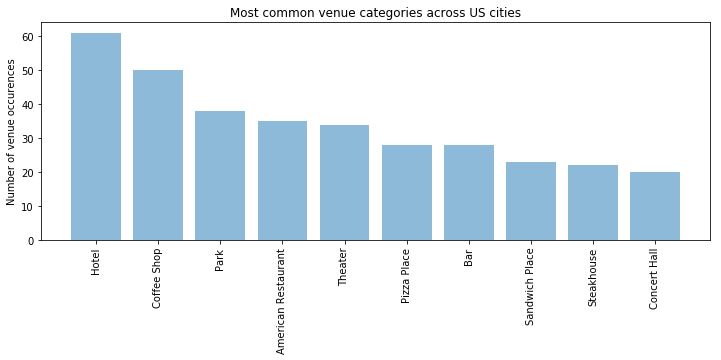

In [60]:
venue_counts = venue_df["Venue_category"].value_counts().head(10)

plt.figure(figsize=(12,4))
categories = venue_counts.index.values
y_pos = np.arange(len(categories))
counts = venue_counts.values

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories, rotation="vertical")
plt.ylabel('Number of venue occurences')
plt.title('Most common venue categories across US cities')

plt.show()

We can see that most of the venues used in the analysis are of type Hotel. This was to be expected as the Foursquare API search starts from each city's center and includes search results in a 5000 meter radius. The center of a city is normally very crowded with tourists that need to be accomodated.

## e.) Provide a first visual representation of the venues in each city that will be used for machine learning
Initial zoom is on the USA. Please feel free to zoom in to see all the venues that were used for analysis

In [61]:
map = folium.Map(location=[39.381266, -97.922211], zoom_start=3)
for name, lat, lng in zip(venue_df["Venue_name"], venue_df["Venue_latitude"], venue_df["Venue_longitude"]):
    name = name.replace("'", "")
    folium.CircleMarker(
        location=[lat, lng],
        fill= True,
        fill_color = "Black",
        radius=10,
        popup= name
    ).add_to(map)
map

### f.) Pre-processing data for a Kmeans clustering algorithm (on the basis of venues of part "e")

We will use each city's venue categories to run the machine learning. As Kmeans cannot process non-numeric data, we will need to use onehot processing. We then group by City and then calculate the mean to get a single row of results of each category per city.

In [62]:
global_onehot = pd.get_dummies(venue_df["Venue_category"])
global_onehot.insert(loc=0, column="City", value= venue_df["City"])
global_grouped = global_onehot.groupby(by="City").mean().reset_index()
global_grouped.head()

,City,Accessories Store,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Albuquerque,0.0,0.05,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.05
1,Arlington,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.05,0.05,0.0,0.0,0.05,0.0,0.00
2,Atlanta,0.0,0.00,0.0,0.00,0.0,0.05,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.05,0.0,0.00
3,Austin,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00
4,Baltimore,0.0,0.00,0.0,0.05,0.0,0.00,0.0,0.0,0.05,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00


### g.) Creation of a summary dataframe with all important data by merging previous dataframes

We create a dataframe that includes all the previous information we collected. We add the 10 most common categories.

In [63]:
top_venue_categories = 10
appendices = ["st", "nd", "rd"]
columns = []

# Create columns of new dataframe
for i in np.arange(top_venue_categories):
    try:
        columns.append("{}{} most common category".format(i+1, appendices[i]))
    except:
        columns.append("{}th most common category".format(i+1))

# Create dataframe
summary_df = pd.DataFrame(columns= columns)
summary_df.insert(loc=0, column="City", value=global_grouped["City"])

def sort_rows_by_frequency(row, top_values):
    row_categories_sorted = row.sort_values(ascending=False)
    return row_categories_sorted.index.values[:top_values]

# Populate dataframe
for i in np.arange(global_grouped.shape[0]):
    summary_df.iloc[i, 1:] = sort_rows_by_frequency(global_grouped.iloc[i, 1:], top_venue_categories)

### h.) Train and run clustering machine learning algorithm (Kmeans)

We train and run the Kmeans clustering algorithm. After that, we add the cluster label of each city to the summary dataframe created above

In [64]:
cluster_df = global_grouped.drop("City", axis=1)
num_clusters = 4

#Train model
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(cluster_df)
summary_df.insert(loc=1, column= "Cluster_Label", value=kmeans.labels_)

# Join two dataframes for better overview
summary_df = summary_df.join(df.set_index("City"), on="City")
summary_df

,City,Cluster_Label,1st most common category,2nd most common category,3rd most common category,4th most common category,5th most common category,6th most common category,7th most common category,8th most common category,9th most common category,10th most common category,Size_Folium,Latitude,Longitude
0,Albuquerque,0,Bar,Café,Zoo,Sandwich Place,American Restaurant,Brewery,Burger Joint,Coffee Shop,Design Studio,Diner,0.560218,35.0841034,-106.6509851
1,Arlington,0,Mexican Restaurant,Spa,Furniture / Home Store,Bookstore,Shopping Mall,Donut Shop,Diner,Sandwich Place,Fried Chicken Joint,Sushi Restaurant,0.398112,32.701939,-97.105624826688
2,Atlanta,0,Poke Place,Music Venue,Mediterranean Restaurant,Burger Joint,Latin American Restaurant,Korean Restaurant,Sports Club,Museum,Football Stadium,Cajun / Creole Restaurant,0.498044,33.7490987,-84.3901849
3,Austin,2,Hotel,Capitol Building,Seafood Restaurant,Movie Theater,Bar,Cocktail Bar,Deli / Bodega,Cajun / Creole Restaurant,Burger Joint,Field,0.964254,30.2711286,-97.7436995
4,Baltimore,0,Hotel,Strip Club,Italian Restaurant,Lounge,Farmers Market,Middle Eastern Restaurant,Neighborhood,Deli / Bodega,Peruvian Restaurant,Coffee Shop,0.602495,39.2908816,-76.610759
5,Boston,1,Historic Site,Park,Italian Restaurant,Chocolate Shop,Restaurant,Salad Place,New American Restaurant,Sandwich Place,Deli / Bodega,Seafood Restaurant,0.694583,42.3602534,-71.0582912
6,Charlotte,1,American Restaurant,Restaurant,Theater,Tapas Restaurant,Other Nightlife,Science Museum,Italian Restaurant,Farmers Market,Bakery,Burger Joint,0.872498,35.2270869,-80.8431268
7,Chicago,1,Park,Theater,Hotel,Pet Service,Concert Hall,Outdoor Sculpture,New American Restaurant,Smoke Shop,Fountain,Jazz Club,2.705994,41.8755616,-87.6244212
8,Colorado Springs,0,Coffee Shop,Steakhouse,Hotel,Mediterranean Restaurant,Bar,Brewery,Breakfast Spot,Gym,Bookstore,Liquor Store,0.472688,38.8339578,-104.8253485
9,Columbus,1,Park,Coffee Shop,Hotel,Taco Place,Hockey Arena,Hot Dog Joint,Latin American Restaurant,Deli / Bodega,Pizza Place,Record Shop,0.892533,39.9622601,-83.0007065


We have the final summary dataframe and each city's cluster label that we can use to plot the result on folium

### i.) Show a visual representation of machine learning results on a folium map 

We use the population data of each city to size the bubbles on folium and differentiate each cluster with its color.

In [65]:
# Create random colors from jet colormap
colors_array = cm.jet((np.linspace(0, 1, num_clusters)))
colormap = [colors.rgb2hex(i) for i in colors_array]

#Create folium map
colors_array = cm.jet((np.linspace(0, 1, num_clusters)))
colormap = [colors.rgb2hex(i) for i in colors_array]

cluster_map = folium.Map(location=[39.381266, -97.922211], zoom_start=4)

for city, lat, lng, cluster, size in zip(summary_df["City"], summary_df["Latitude"], summary_df["Longitude"], summary_df["Cluster_Label"], summary_df["Size_Folium"]):
    lat = float(lat)
    lng = float(lng)
    folium.CircleMarker(location=[lat, lng],
                        radius=size + 10,
                        popup="{} ---> Cluster {}".format(city, cluster),
                        fill= True,
                        fill_color= colormap[cluster],
                        fill_opacity= 1
    ).add_to(cluster_map)

cluster_map


### j.) Results section

We can see from the map above that some cities are similar to each other in their characteristics and type of venues most often found within them. In this run we can observe that a few other cities have the same color as NY's circle. As an advisor, I would approach my clients with this map and show them what options they have and where they should move to if they want to find similar characteristics to NY in another city.

### k.) Discussion

The limitations of this report are found in the usage of the Foursquare API. As I used the endpoint "explore" which provides trending and time dependent data, the results of the search and entire analysis might differ when running the script multiple times. Furthermore, I only included 20 venues for each city within a 5000 meter radius around the city center which should be more sophisticated and widespread. However, this would've been way above the free quota on the Foursquare API and thus not feasible for this project.

### l.) Conclusion

While this project, due to the data retrieval limitations of the Foursquare API was rather superficial, I would say that this type of analysis can bring a myriad of insights about cities, neighborhoods etc. A continuation of this project would probably involve analysing the different boroughs of the city chosen by the client and compare it with their current borough/neighborhood in NY. 